In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
def read_test_data():
    Dfs = []
    train_df = []
    coords = pd.read_csv("data_phase_one/coords.csv", header=None)
    for name in ["mslp", "sst", "ssta", "t2m"]:
        df = pd.read_csv(f"./data_phase_one/test_input_{name}_phase_one.csv", header=None)
        print("Shape df", df.shape)
        Dfs.append(df)
        #Dfs.append(df.T.reset_index(drop=True))
    j = 0
    for i in range(0, df.shape[0], 12):
        feat = pd.concat([coords, Dfs[0].iloc[i:i+12], Dfs[1].iloc[i:i+12], Dfs[2].iloc[i:i+12], Dfs[3].iloc[i:i+12]], axis=0).reset_index(drop=True)
        feat = feat.T.reset_index(drop=True)
        feat.columns = [f"feat_{k}" for k in range(feat.shape[1])]
        if j < 3:
            print(feat.columns)
        train_df.append(feat)
        j += 1
    train_df = pd.concat(train_df, axis=0)
    return train_df

In [4]:
test_data = read_test_data()

Shape df (852, 5774)
Shape df (852, 5774)
Shape df (852, 5774)
Shape df (852, 5774)
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30',
       'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36',
       'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42',
       'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48',
       'feat_49'],
      dtype='object')
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24

In [5]:
test_data.shape

(409954, 50)

In [6]:
monthly_stats = np.load("monthly_stats.npy")

In [7]:
monthly_stats = np.tile(monthly_stats,(len(test_data)//5774,1))

In [8]:
monthly_stats_df = pd.DataFrame(monthly_stats, columns=[f"add_feat_{i}" for i in range(24)])

In [9]:
data_rich = pd.concat([test_data.reset_index(drop=True), monthly_stats_df], axis=1)

In [10]:
import joblib

In [11]:
#lgb_model = joblib.load("./trained_models/lgb_model.joblib")
#catb_model = joblib.load("./trained_models/catb_model.joblib")

In [12]:
#y_pred1 = lgb_model.predict(test_data.values)
#y_pred2 = catb_model.predict(test_data.values)

In [13]:
#y_pred = 0.2*y_pred1 + 0.8*y_pred2 ==> -0.06
#y_pred = 0.55*y_pred1 + 0.45*y_pred2 ==> -0.03
#y_pred = 0.8*y_pred1 + 0.2*y_pred2 ==> -0.01
#y_pred = 0.95*y_pred1 + 0.05*y_pred2 ==> -0.0012
#y_pred = 0.99*y_pred1 - 0.01*y_pred2 ==> 0.0032

In [14]:
#y_pred = 0.99*y_pred1 - 0.01*y_pred2

In [15]:
#pred_df = pd.DataFrame(y_pred.reshape(71, 5774))

In [16]:
#pred_df

In [17]:
#pred_df.to_csv("./predictions.csv", index=False, header=False)

## K-Fold Predictions

In [18]:
import os
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler

In [19]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, coeffs):
        super().__init__()
        self.estimators = estimators
        self.coeffs = coeffs
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [coeff*estimator.predict(X) for estimator, coeff in zip(self.estimators, self.coeffs)]
        return np.sum(y_preds, axis=0)

In [20]:
def load_boosting_models(path, num_folds=5):
    Models = []
    for fold in range(num_folds):
        for model_name in ["catb", "lgb"]:
            for trained_model_path in os.listdir(path):
                if trained_model_path.startswith("."): continue
                if model_name in trained_model_path and f'fold{fold}' in trained_model_path:
                    model = joblib.load(f'{path}/{trained_model_path}')
                    Models.append(model)
    return Models

In [45]:
def load_xgb_models(path, num_folds=5):
    Models = []
    for fold in range(num_folds):
        for model_name in ["xgb"]:
            for trained_model_path in os.listdir(path):
                if trained_model_path.startswith("."): continue
                if model_name in trained_model_path and f'fold{fold}' in trained_model_path:
                    model = joblib.load(f'{path}/{trained_model_path}')
                    Models.append(model)
    return Models

In [46]:
boosting_models = load_boosting_models("./kfold_trained2/", 5)
coeffs = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
assert sum(coeffs) == 1
boosting_models = VotingModel(boosting_models, coeffs)

In [47]:
add_feat_boosting_models = VotingModel(load_boosting_models("./trained3/"), coeffs)

In [24]:
#scaler = joblib.load("./kfold_trained_preproc/Scaler.joblib")

In [25]:
from pytorch_implementation.dataset import Dataset
from pytorch_implementation.helper_funcs import *

In [48]:
trained_nn_models = load_trained("./trained_models_nn")

In [49]:
#y_pred_xgb = xgb_models.predict(test_data.values)

In [50]:
y_pred_boost = boosting_models.predict(test_data.values)
y_pred_add_feat = add_feat_boosting_models.predict(data_rich.values)
y_pred_gru = average_prediction(test_data.values, trained_nn_models[0::2])
y_pred_lstm = average_prediction(test_data.values, trained_nn_models[1::2])

In [51]:
y_pred_add_feat

array([0.41890305, 0.60527185, 0.47927709, ..., 0.1407996 , 0.12893621,
       0.67350551])

In [52]:
y_pred_lstm

array([[0.408053  ],
       [0.55129457],
       [0.4076072 ],
       ...,
       [0.21938394],
       [0.18747286],
       [0.5706732 ]], dtype=float32)

In [53]:
y_pred_gru

array([[0.3978323 ],
       [0.5199488 ],
       [0.41578475],
       ...,
       [0.12658595],
       [0.09968101],
       [0.3182867 ]], dtype=float32)

In [54]:
y_pred_boost

array([0.41524715, 0.60974182, 0.50326399, ..., 0.16638249, 0.1230431 ,
       0.5932267 ])

In [55]:
#y_pred = 0.15*y_pred_preproc + 0.85*(0.9*y_pred_boost + 0.03*y_pred_gru.squeeze() + 0.07*y_pred_lstm.squeeze())
y_pred = 0.28*y_pred_add_feat + 0.95*(0.92*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.09*y_pred_lstm.squeeze())

In [56]:
pred_df = pd.DataFrame(y_pred.reshape(71, 5774))

In [57]:
pred_df

,0,1,2,3,4,5,6,7,8,9,...,5764,5765,5766,5767,5768,5769,5770,5771,5772,5773
0,0.518887,0.754466,0.612851,0.326934,0.249195,0.241115,0.208641,0.247317,0.213735,0.209538,...,0.027983,-0.007126,0.192913,0.150446,0.063116,0.137229,0.348811,0.158748,0.664158,0.938543
1,-0.563742,-0.612001,-0.582615,-0.578963,-0.751111,-0.645697,-0.526236,-0.456318,-0.402992,-0.493958,...,-0.263092,-0.265421,0.070233,0.195173,0.293732,0.348755,0.403343,0.436000,0.581960,1.015695
2,-0.121760,-0.072309,-0.037488,-0.085996,-0.079602,-0.081767,-0.072804,-0.058444,-0.056422,-0.060485,...,0.027962,0.032348,0.282928,0.362873,0.412671,0.400874,0.514729,0.422171,0.526793,0.503655
3,-0.162525,-0.233230,-0.128964,-0.149708,-0.108982,-0.043341,-0.026862,-0.033304,-0.026308,-0.030664,...,-0.402386,-0.307914,-0.197391,-0.132606,-0.059198,0.036104,-0.082673,-0.121003,0.008406,-0.041994
4,-0.657148,-0.404857,-0.409061,-0.555781,-0.546314,-0.426795,-0.333510,-0.312369,-0.477824,-0.501491,...,-0.563327,-0.607224,-0.351501,-0.167355,-0.019708,0.065263,-0.030173,0.142362,0.406454,0.090964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.635850,0.501437,0.438266,0.278632,0.112218,0.070116,0.093378,0.180282,0.140607,0.144490,...,-0.222255,-0.265818,0.105858,0.254848,0.309418,0.434448,0.466764,0.389369,0.647557,0.400223
67,0.201048,0.243728,0.273268,0.149850,0.111102,0.079377,0.095234,0.089624,0.089231,0.056123,...,-0.177734,-0.074737,0.196390,0.348160,0.393102,0.431962,0.563236,0.333645,0.542545,0.465794
68,-0.310698,-0.285322,-0.292745,-0.322902,-0.281545,-0.357596,-0.282389,-0.216150,-0.250274,-0.212650,...,0.538765,0.539444,0.688987,0.716118,0.597762,0.569429,0.889669,0.733776,0.829854,0.568447
69,0.057670,-0.019896,0.076914,0.058267,0.059332,0.052044,0.057404,0.050053,0.037636,0.003254,...,-0.136896,-0.054151,0.397138,0.439309,0.456047,0.378451,0.435175,0.175373,0.313118,-0.057834


In [58]:
pred_df.to_csv("./predictions.csv", index=False, header=False)

In [59]:
best_sub = pd.read_csv(f"./submissions/predictions12.zip", header=None)

In [60]:
best_sub

,0,1,2,3,4,5,6,7,8,9,...,5764,5765,5766,5767,5768,5769,5770,5771,5772,5773
0,0.413519,0.610221,0.499384,0.261020,0.199013,0.194932,0.173647,0.204035,0.173151,0.168073,...,0.024862,-0.002499,0.151940,0.115988,0.048577,0.114184,0.286915,0.133223,0.542846,0.747106
1,-0.452064,-0.495839,-0.472238,-0.467548,-0.600497,-0.517502,-0.423907,-0.365181,-0.319681,-0.393909,...,-0.210361,-0.209763,0.051806,0.154276,0.231007,0.285622,0.324772,0.353552,0.472415,0.868721
2,-0.098479,-0.062061,-0.031402,-0.070501,-0.066312,-0.068666,-0.061480,-0.049271,-0.046419,-0.048812,...,0.032404,0.033227,0.238023,0.295192,0.332893,0.342720,0.420706,0.350446,0.431909,0.386909
3,-0.126822,-0.187531,-0.105933,-0.117853,-0.084037,-0.032493,-0.018411,-0.026380,-0.018053,-0.022163,...,-0.328681,-0.255022,-0.169168,-0.114252,-0.053195,0.030705,-0.072592,-0.096501,0.006179,-0.035856
4,-0.536948,-0.334909,-0.339579,-0.455822,-0.442817,-0.349786,-0.273940,-0.252942,-0.389090,-0.405370,...,-0.449169,-0.482486,-0.279273,-0.134238,-0.017018,0.054762,-0.022953,0.118007,0.331882,0.063182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.519552,0.410995,0.358057,0.223648,0.094411,0.064560,0.083027,0.149745,0.117536,0.122499,...,-0.179646,-0.212669,0.087145,0.206457,0.247627,0.358802,0.381744,0.324395,0.529960,0.348364
67,0.167025,0.197994,0.220118,0.122964,0.086943,0.061327,0.075242,0.071843,0.070730,0.044062,...,-0.142170,-0.062521,0.156058,0.279388,0.314744,0.354872,0.456533,0.264167,0.435926,0.348064
68,-0.247008,-0.236514,-0.240609,-0.267419,-0.228312,-0.291850,-0.229150,-0.173707,-0.200420,-0.167777,...,0.431649,0.433571,0.556033,0.574702,0.478248,0.468813,0.741000,0.602561,0.687212,0.458889
69,0.040434,-0.021600,0.059565,0.044246,0.041899,0.040521,0.044695,0.038863,0.029103,0.000747,...,-0.109956,-0.048006,0.315147,0.347591,0.362124,0.303917,0.348851,0.132392,0.240881,-0.080829


In [61]:
import matplotlib.pyplot as plt

In [62]:
cols = [0, 1003, 273]

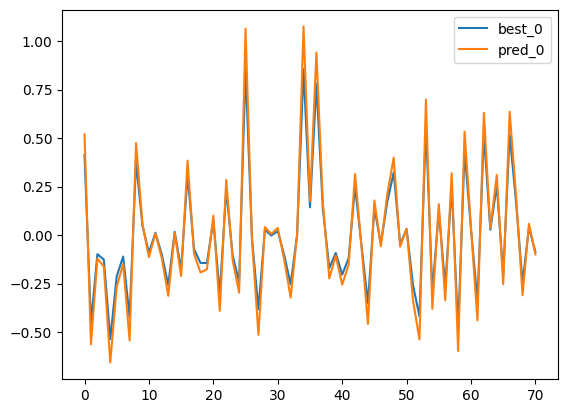

In [63]:
plt.plot(best_sub[cols[0]])
plt.plot(pred_df[cols[0]])

plt.legend([f"best_{cols[0]}", f"pred_{cols[0]}"])
plt.show()

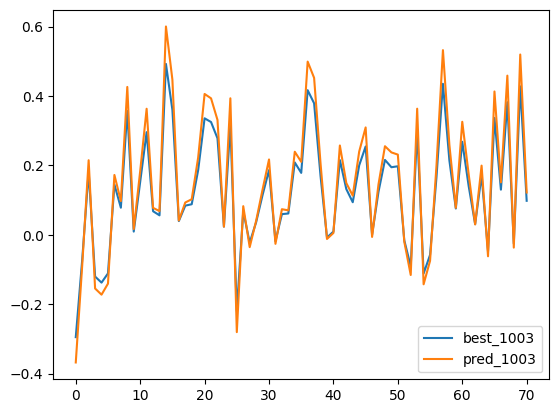

In [64]:
plt.plot(best_sub[cols[1]])
plt.plot(pred_df[cols[1]])

plt.legend([f"best_{cols[1]}", f"pred_{cols[1]}"])
plt.show()

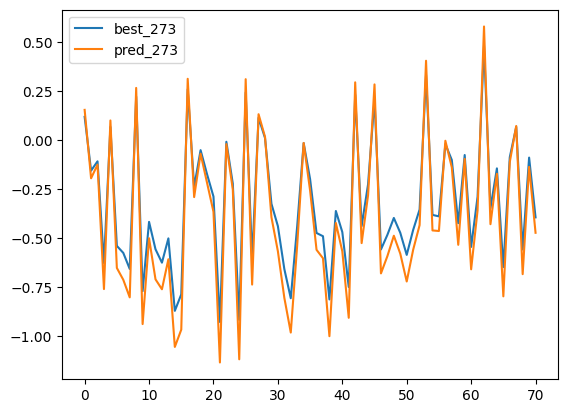

In [65]:
plt.plot(best_sub[cols[2]])
plt.plot(pred_df[cols[2]])

plt.legend([f"best_{cols[2]}", f"pred_{cols[2]}"])
plt.show()

## kfold_trained2 is current best

In [44]:
# KFold

# catb 500 estimators, lgbm 1000 estimators
# [0.05, 0.15, 0.05, 0.15, 0.05, 0.15, 0.05, 0.15, 0.05, 0.15] ==> 0.093

# catb and lgb 1000 estimators
# [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] ==> 0.094

# catb and lgb 1000 estimators
# ([0.08, 0.12, 0.08, 0.12, 0.1, 0.1, 0.1, 0.1, 0.06, 0.14])*0.91 + 0.01*gru + 0.09*lstm ==> 0.0951
# y_pred = 0.25*y_pred_add_feat + 0.90*(0.91*y_pred_boost + 0.02*y_pred_gru.squeeze() + 0.10*y_pred_lstm.squeeze()) ==> 0.0985
# y_pred = 0.28*y_pred_add_feat + 0.95*(0.92*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.09*y_pred_lstm.squeeze()) ==> 0.09862
# y_pred = 0.91*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.09*y_pred_lstm.squeeze()